In [461]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, calinski_harabasz_score
from sklearn.impute import SimpleImputer


In [462]:
# Загрузка данных
df = pd.read_csv('data_tms.csv')
print("Размер датасета:", df.shape)
df.head()

Размер датасета: (891, 12)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [463]:
print("Размер датасета:", df.shape)
print("\nПервые 5 строк:")
df.head()

Размер датасета: (891, 12)

Первые 5 строк:


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [464]:
print("Информация о данных:")
df.info()

Информация о данных:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [465]:
print("Пропущенные значения:")
df.isnull().sum()

Пропущенные значения:


PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

Предобработка данных

In [466]:
data = df.copy()

y = data['Survived']

columns_to_drop = ['Survived', 'PassengerId', 'Name', 'Ticket', 'Cabin', 'Pclass','Sex','SibSp','Parch','Embarked']
data = data.drop(columns=[col for col in columns_to_drop if col in data.columns])

print("Оставшиеся признаки:")
print(data.columns.tolist())

Оставшиеся признаки:
['Age', 'Fare']


In [467]:
categorical_cols = data.select_dtypes(include=['object']).columns.tolist()
print("Категориальные признаки:", categorical_cols)

# Кодируем категориальные переменные
label_encoders = {}
for col in categorical_cols:
    if col in data.columns:
        le = LabelEncoder()
        # Заполняем пропуски модой перед кодированием
        mode_val = data[col].mode()[0] if not data[col].mode().empty else 'Unknown'
        data[col] = data[col].fillna(mode_val)
        data[col] = le.fit_transform(data[col].astype(str))
        label_encoders[col] = le

# %%
# Обработка числовых переменных
numeric_cols = data.select_dtypes(include=[np.number]).columns.tolist()
print("Числовые признаки:", numeric_cols)

# Заполняем пропуски в числовых переменных
imputer = SimpleImputer(strategy='median')
data[numeric_cols] = imputer.fit_transform(data[numeric_cols])

# %%
print("Данные после предобработки:")
print(data.head())
print(f"\nРазмер данных: {data.shape}")

Категориальные признаки: []
Числовые признаки: ['Age', 'Fare']
Данные после предобработки:
    Age     Fare
0  22.0   7.2500
1  38.0  71.2833
2  26.0   7.9250
3  35.0  53.1000
4  35.0   8.0500

Размер данных: (891, 2)


In [468]:
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)

print("Данные после стандартизации:")
print(pd.DataFrame(data_scaled, columns=data.columns).head())

Данные после стандартизации:
        Age      Fare
0 -0.565736 -0.502445
1  0.663861  0.786845
2 -0.258337 -0.488854
3  0.433312  0.420730
4  0.433312 -0.486337


Метод локтя для определения оптимального числа кластеров (K-means)

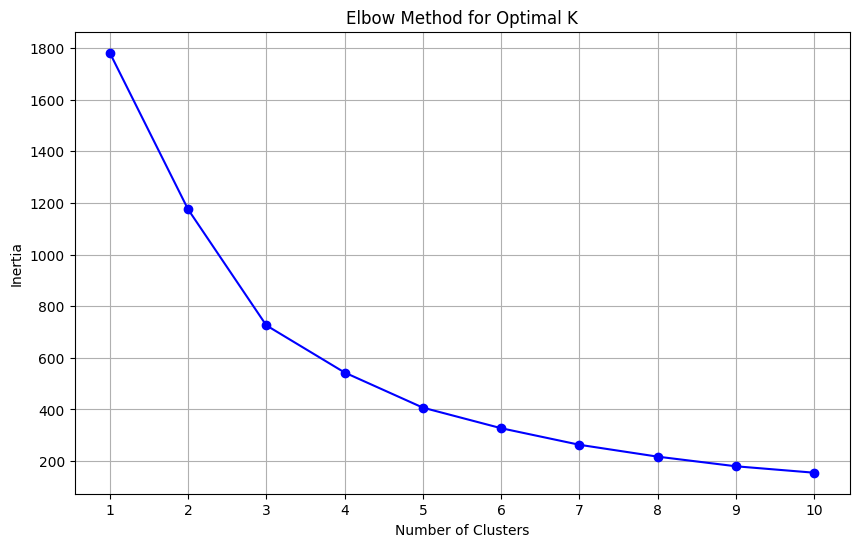

In [469]:
inertia = []
k_range = range(1, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(data_scaled)
    inertia.append(kmeans.inertia_)

# %%
plt.figure(figsize=(10, 6))
plt.plot(k_range, inertia, 'bo-')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal K')
plt.xticks(k_range)
plt.grid(True)
plt.show()

Выбираем 3 кластера

Кластеризация K-means

In [470]:
# Выбираем оптимальное количество кластеров
optimal_k = 3
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
kmeans_labels = kmeans.fit_predict(data_scaled)

# %%
# Добавляем метки кластеров в исходный датасет для анализа
df_analysis = df.copy()
df_analysis['KMeans_Cluster'] = kmeans_labels

print("Распределение по кластерам K-means:")
print(df_analysis['KMeans_Cluster'].value_counts().sort_index())

Распределение по кластерам K-means:
KMeans_Cluster
0    198
1    657
2     36
Name: count, dtype: int64


Кластеризация DBSCAN

In [471]:
#Подбор параметров для DBSCAN
dbscan = DBSCAN(eps=0.25, min_samples=10)
dbscan_labels = dbscan.fit_predict(data_scaled)

# %%
# Анализ результатов DBSCAN
unique_labels = np.unique(dbscan_labels)
n_clusters = len(unique_labels) - (1 if -1 in dbscan_labels else 0)
n_noise = list(dbscan_labels).count(-1)

print(f"DBSCAN результаты:")
print(f"Количество кластеров: {n_clusters}")
print(f"Количество шумовых точек: {n_noise}")
print(f"Метки кластеров: {unique_labels}")

# %%
df_analysis['DBSCAN_Cluster'] = dbscan_labels

print("Распределение по кластерам DBSCAN:")
print(df_analysis['DBSCAN_Cluster'].value_counts().sort_index())

DBSCAN результаты:
Количество кластеров: 1
Количество шумовых точек: 140
Метки кластеров: [-1  0]
Распределение по кластерам DBSCAN:
DBSCAN_Cluster
-1    140
 0    751
Name: count, dtype: int64


Визуализация кластеров с помощью PCA

Объясненная дисперсия PCA: 1.000


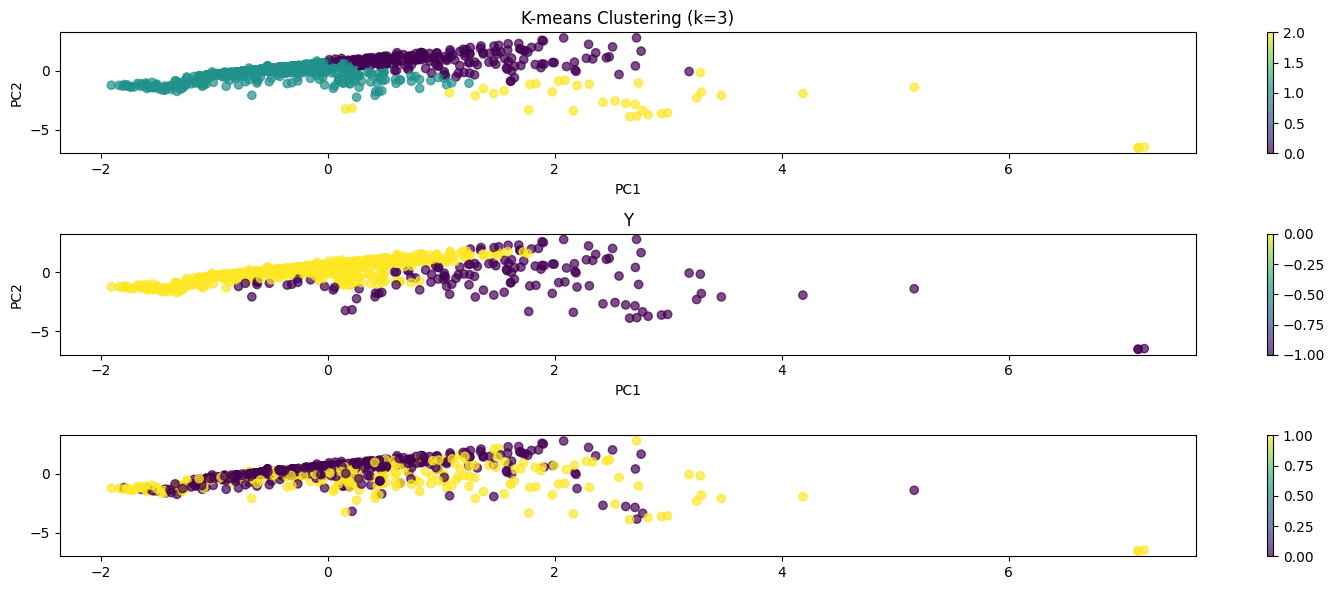

In [472]:
# Применяем PCA для визуализации в 2D
pca = PCA(n_components=2)
data_pca = pca.fit_transform(data_scaled)

print(f"Объясненная дисперсия PCA: {pca.explained_variance_ratio_.sum():.3f}")

# %%
# Создаем subplot для сравнения методов
fig, axes = plt.subplots(3, 1, figsize=(15, 6))
ax1, ax2, ax3 = axes.flatten()


# K-means визуализация
scatter1 = ax1.scatter(data_pca[:, 0], data_pca[:, 1], c=kmeans_labels, 
                      cmap='viridis', alpha=0.7)
ax1.set_title(f'K-means Clustering (k={optimal_k})')
ax1.set_xlabel('PC1')
ax1.set_ylabel('PC2')
plt.colorbar(scatter1, ax=ax1)

# DBSCAN визуализация
scatter2 = ax2.scatter(data_pca[:, 0], data_pca[:, 1], c=dbscan_labels, 
                      cmap='viridis', alpha=0.7)
ax2.set_title('DBSCAN Clustering')
ax2.set_xlabel('PC1')
ax2.set_ylabel('PC2')
plt.colorbar(scatter2, ax=ax2)

scatter3 = ax3.scatter(data_pca[:, 0], data_pca[:, 1], c=y, 
                      cmap='viridis', alpha=0.7)
ax2.set_title('Y')
ax2.set_xlabel('PC1')
ax2.set_ylabel('PC2')
plt.colorbar(scatter3, ax=ax3)

plt.tight_layout()
plt.show()


Посмотрим сколько аномальных точек dbscan попало в выживших

In [481]:
mapped_dbscan = dbscan_labels
#mapped_dbscan = np.where(mapped_dbscan == 0, 1, mapped_dbscan)
mapped_dbscan = np.where(mapped_dbscan == -1, 1, mapped_dbscan)
TP = np.sum((mapped_dbscan == 1) & (y == 1))
FN = np.sum((mapped_dbscan == 0) & (y == 1))
FP = np.sum((mapped_dbscan == 1) & (y == 0))
TN = np.sum((mapped_dbscan == 0) & (y == 0))
accurace = (TP + TN) / len(y)


# Точность (Accuracy) - общая доля правильных прогнозов
accuracy = (TP + TN) / (TP + FP + TN + FN)

# Точность/Precision - доля правильных прогнозов среди предсказанных 1
precision = TP / (TP + FP) if (TP + FP) > 0 else 0

# Полнота/Recall - доля правильных прогнозов среди реальных 1  
recall = TP / (TP + FN) if (TP + FN) > 0 else 0

# F1-score - гармоническое среднее precision и recall
f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

print("\n=== Основные метрики ===")
print(f"Accuracy (Точность):  {accuracy:.4f}")
print(f"Precision (Точность): {precision:.4f}")
print(f"Recall (Полнота):     {recall:.4f}")
print(f"F1-Score:             {f1_score:.4f}")



=== Основные метрики ===
Accuracy (Точность):  0.6566
Precision (Точность): 0.6286
Recall (Полнота):     0.2573
F1-Score:             0.3651


Оценка качества кластеризации

In [474]:
# Функция для оценки кластеризации (только если есть более 1 кластера)
def evaluate_clustering(labels, data, method_name):
    unique_labels = np.unique(labels)
    if len(unique_labels) > 1 and len(unique_labels) < len(data):
        try:
            silhouette = silhouette_score(data, labels)
            calinski = calinski_harabasz_score(data, labels)
            print(f"{method_name}:")
            print(f"  Silhouette Score: {silhouette:.3f}")
            print(f"  Calinski-Harabasz Score: {calinski:.3f}")
        except:
            print(f"{method_name}: Невозможно вычислить метрики")
    else:
        print(f"{method_name}: Недостаточно кластеров для оценки")

# %%
print("Метрики качества кластеризации:")
evaluate_clustering(kmeans_labels, data_scaled, "K-means")
evaluate_clustering(dbscan_labels, data_scaled, "DBSCAN")

Метрики качества кластеризации:
K-means:
  Silhouette Score: 0.510
  Calinski-Harabasz Score: 645.966
DBSCAN:
  Silhouette Score: 0.513
  Calinski-Harabasz Score: 323.819


Анализ характеристик кластеров (K-means)

Центроиды кластеров K-means (оригинальный масштаб):
Средние значения по кластерам K-means:


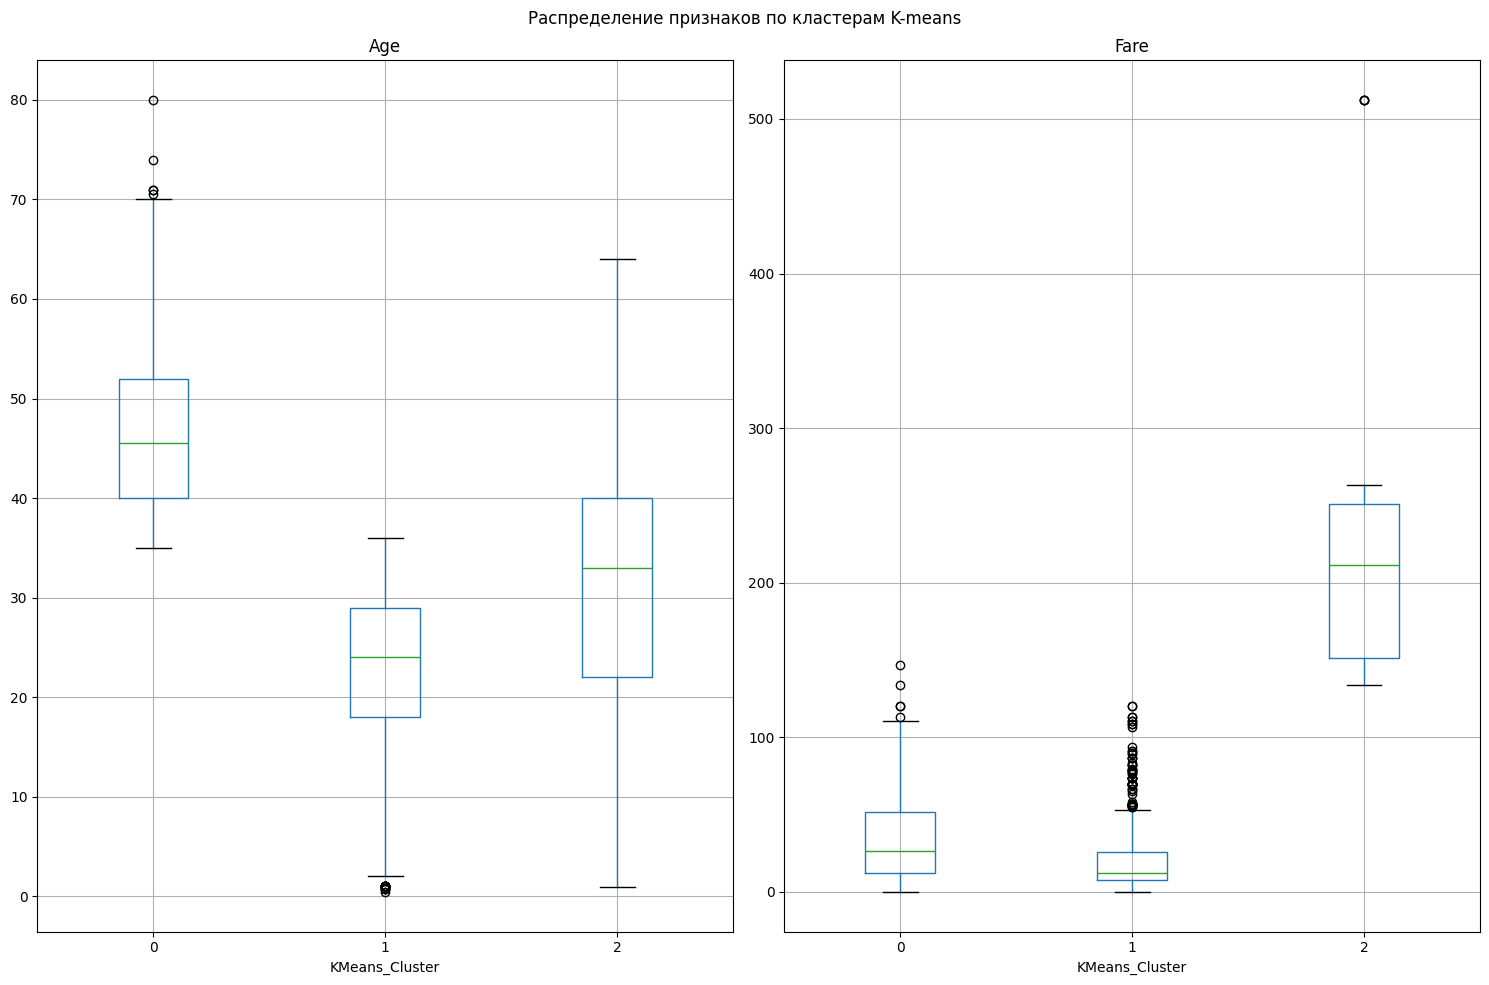

In [475]:
# Анализ центроидов кластеров K-means
centroids = scaler.inverse_transform(kmeans.cluster_centers_)
centroids_df = pd.DataFrame(centroids, columns=data.columns)

print("Центроиды кластеров K-means (оригинальный масштаб):")
centroids_df

# %%
# Анализ средних значений по кластерам
cluster_analysis = df_analysis.groupby('KMeans_Cluster').agg({
    'Age': 'mean',
    'Fare': 'mean'
}).round(2)

print("Средние значения по кластерам K-means:")
cluster_analysis

# %%
# Визуализация характеристик кластеров
fig, axes = plt.subplots(1, 2, figsize=(15, 10))
axes = axes.ravel()

features_to_plot = ['Age', 'Fare']

for i, feature in enumerate(features_to_plot):
    if feature in df_analysis.columns:
        if feature == 'Sex':
            # Для пола считаем долю женщин
            gender_by_cluster = df_analysis.groupby('KMeans_Cluster')['Sex'].value_counts(normalize=True).unstack()
            if 'female' in gender_by_cluster.columns:
                gender_by_cluster['female'].plot(kind='bar', ax=axes[i], title=f'{feature} by Cluster')
        else:
            df_analysis.boxplot(column=feature, by='KMeans_Cluster', ax=axes[i])

plt.suptitle('Распределение признаков по кластерам K-means')
plt.tight_layout()
plt.show()

Сравнительный анализ методов

In [476]:
# Создаем сводную таблицу для сравнения
comparison = pd.DataFrame({
    'Method': ['K-means', 'DBSCAN'],
    'Number_of_Clusters': [optimal_k, n_clusters],
    'Noise_Points': [0, n_noise],
    'Silhouette_Score': [
        silhouette_score(data_scaled, kmeans_labels) if len(np.unique(kmeans_labels)) > 1 else None,
        silhouette_score(data_scaled, dbscan_labels) if len(np.unique(dbscan_labels)) > 1 else None
    ]
})

print("Сравнение методов кластеризации:")
print(comparison)

Сравнение методов кластеризации:
    Method  Number_of_Clusters  Noise_Points  Silhouette_Score
0  K-means                   3             0          0.510182
1   DBSCAN                   1           140          0.513342


Дополнительная визуализация: распределение выживаемости по кластерам

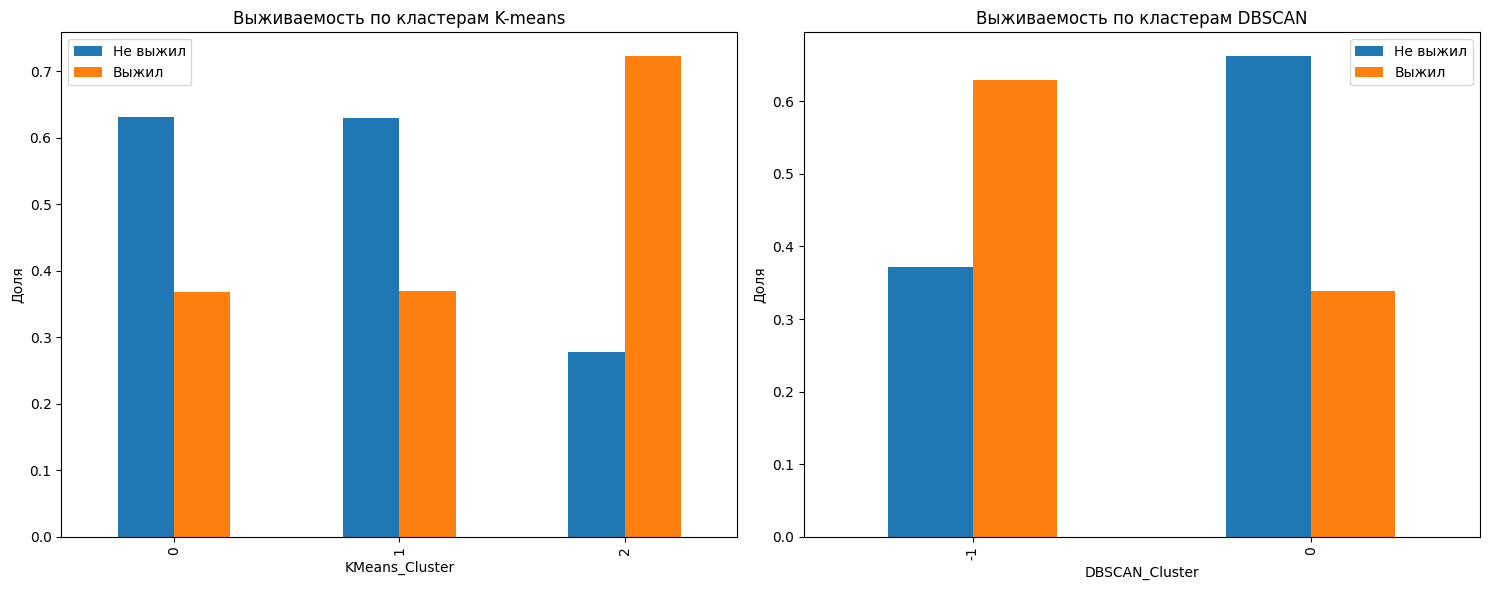


## Основные выводы:

1. **K-means**:
   - Создает четко разделенные кластеры фиксированного количества
   - Хорошо работает, когда данные имеют сферическую форму
   - Легко интерпретировать результаты

2. **DBSCAN**:
   - Автоматически определяет количество кластеров
   - Устойчив к выбросам (помечает их как шум)
   - Лучше справляется с кластерами произвольной формы
   - Требует тонкой настройки параметров eps и min_samples

3. **Для датасета Титаник**:
   - Оба метода выявили интересные группировки пассажиров
   - Кластеры могут соответствовать различным социально-демографическим группам
   - Результаты можно использовать для дальнейшего анализа паттернов выживаемости

Результаты кластеризации сохранены в файл 'titanic_clustering_results.csv'


In [477]:
if 'Survived' in df_analysis.columns:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # K-means
    survival_kmeans = pd.crosstab(df_analysis['KMeans_Cluster'], df_analysis['Survived'], normalize='index')
    survival_kmeans.plot(kind='bar', ax=ax1, title='Выживаемость по кластерам K-means')
    ax1.set_ylabel('Доля')
    ax1.legend(['Не выжил', 'Выжил'])
    
    # DBSCAN
    survival_dbscan = pd.crosstab(df_analysis['DBSCAN_Cluster'], df_analysis['Survived'], normalize='index')
    survival_dbscan.plot(kind='bar', ax=ax2, title='Выживаемость по кластерам DBSCAN')
    ax2.set_ylabel('Доля')
    ax2.legend(['Не выжил', 'Выжил'])
    
    plt.tight_layout()
    plt.show()

# %% [markdown]
# ## Выводы

# %%
print("""
## Основные выводы:

1. **K-means**:
   - Создает четко разделенные кластеры фиксированного количества
   - Хорошо работает, когда данные имеют сферическую форму
   - Легко интерпретировать результаты

2. **DBSCAN**:
   - Автоматически определяет количество кластеров
   - Устойчив к выбросам (помечает их как шум)
   - Лучше справляется с кластерами произвольной формы
   - Требует тонкой настройки параметров eps и min_samples

3. **Для датасета Титаник**:
   - Оба метода выявили интересные группировки пассажиров
   - Кластеры могут соответствовать различным социально-демографическим группам
   - Результаты можно использовать для дальнейшего анализа паттернов выживаемости
""")

# %%
# Сохраняем результаты
results_df = df_analysis[['KMeans_Cluster', 'DBSCAN_Cluster']]
results_df.to_csv('titanic_clustering_results.csv', index=False)
print("Результаты кластеризации сохранены в файл 'titanic_clustering_results.csv'")

Возьмем возраст, стоимость билета и выживаемость и построим распределение на плоскости

In [478]:
data = df.copy()

data = data[['Survived', 'Fare', 'Age']]
#data['Fare'] = np.exp2(data['Fare'])
#data = data['Survived', 'PassengerId', 'Name', 'Ticket', 'Cabin']columns_to_drop = ['Survived', 'PassengerId', 'Name', 'Ticket', 'Cabin']
#data = data.drop(columns=[col for col in columns_to_drop if col in data.columns])

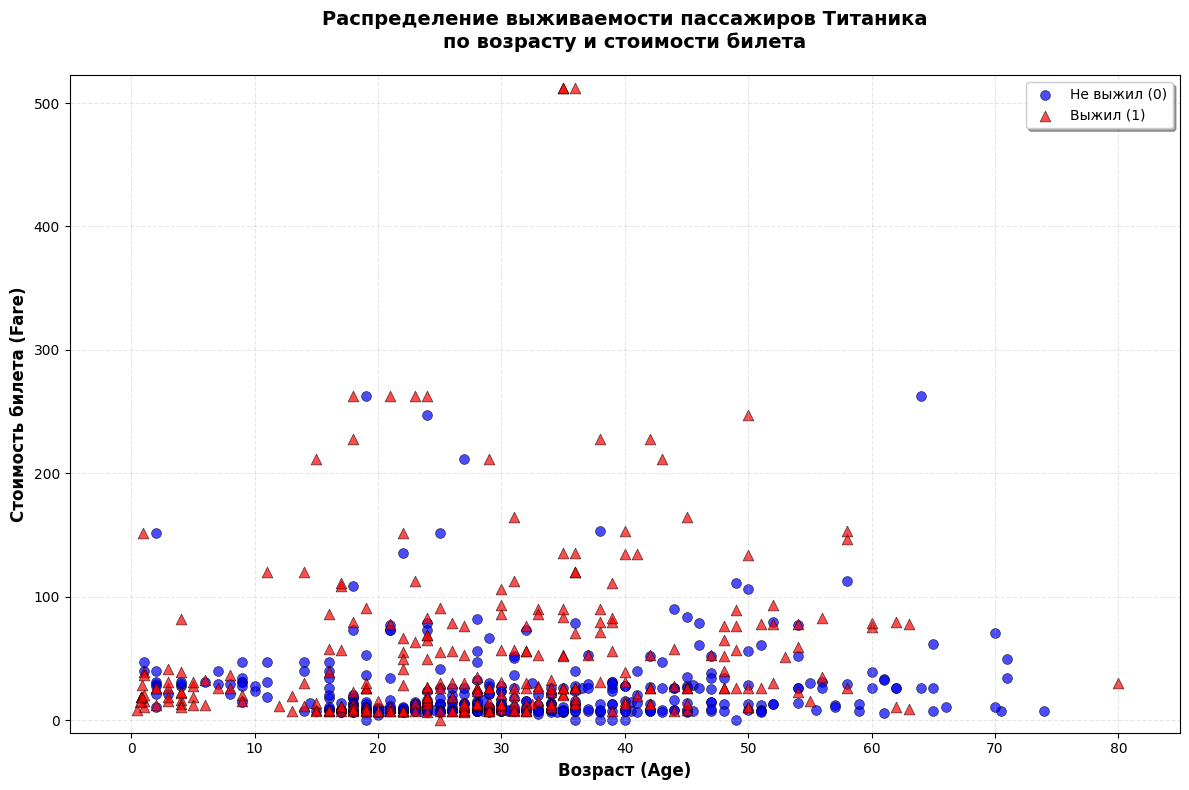

In [479]:
# Создаем фигуру и оси
plt.figure(figsize=(12, 8))

# Разделяем данные на выживших и не выживших
survived = data[data['Survived'] == 1]
not_survived = data[data['Survived'] == 0]

# Создаем scatter plot
# Не выжившие - синие круги
plt.scatter(not_survived['Age'], not_survived['Fare'], 
           c='blue', marker='o', s=50, alpha=0.7, 
           label='Не выжил (0)', edgecolors='black', linewidth=0.5)

# Выжившие - красные треугольники
plt.scatter(survived['Age'], survived['Fare'], 
           c='red', marker='^', s=60, alpha=0.7,
           label='Выжил (1)', edgecolors='black', linewidth=0.5)

# Настройка оформления
plt.xlabel('Возраст (Age)', fontsize=12, fontweight='bold')
plt.ylabel('Стоимость билета (Fare)', fontsize=12, fontweight='bold')
plt.title('Распределение выживаемости пассажиров Титаника\nпо возрасту и стоимости билета', 
          fontsize=14, fontweight='bold', pad=20)

# Добавляем легенду
plt.legend(loc='upper right', frameon=True, fancybox=True, shadow=True)

# Добавляем сетку для лучшей читаемости
plt.grid(True, alpha=0.3, linestyle='--')

# Настройка пределов осей (опционально)
plt.xlim(-5, data['Age'].max() + 5)
plt.ylim(-10, data['Fare'].max() + 10)

# Улучшаем layout
plt.tight_layout()

# Показываем график
plt.show()